In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys, time, pickle
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import quantum_nodes as q
# from my_code import pytorch_model as m

In [3]:
def time_left(time_start, n_epochs_total, n_batches_total, n_epochs_done, current_batch):
    time_left = (time.time() - time_start) * (n_epochs_total*n_batches_total / (n_epochs_done*n_batches_total + current_batch) - 1)
    total_hours = int(time_left // 3600)
    total_minutes = int((time_left - total_hours * 3600) // 60)
    total_seconds = int(time_left - total_hours * 3600 - total_minutes * 60)

    # remaining time for the current epoch
    time_left_epoch = (time.time() - time_start) / (n_epochs_done*n_batches_total + current_batch) * (n_batches_total - current_batch)
    epoch_hours = int(time_left_epoch // 3600)
    epoch_minutes = int((time_left_epoch - epoch_hours * 3600) // 60)
    epoch_seconds = int(time_left_epoch - epoch_hours * 3600 - epoch_minutes * 60)

    return epoch_hours, epoch_minutes, epoch_seconds, total_hours, total_minutes, total_seconds

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



# Define the VAE model
class VAE(nn.Module):

    N_EMB = 18
    RNN_types_dict = {'LSTM': nn.LSTM, 'GRU': nn.GRU, 'RNN': nn.RNN}

    def __init__(self, emb_dim:int, latent_dim:int, output_dim:int, RNN_type:str, RNN_units:list, bidirectional:bool=True, dropout:float=0, num_layers:int=2, one_hot:bool=False):
        super(VAE, self).__init__()

        # Define the hyperparameters
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.RNN_type = RNN_type
        self.RNN_units = RNN_units if isinstance(RNN_units, list) else [RNN_units]
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.num_layers = num_layers
        self.one_hot = one_hot
        # TODO: add temperature for softmax

        # Encoder and Decoder
        self.encoder = VAE.Encoder(emb_dim, latent_dim, RNN_type, RNN_units, bidirectional, dropout, num_layers)
        self.decoder = VAE.Decoder(latent_dim, output_dim, RNN_type, RNN_units[::-1], bidirectional, dropout, num_layers, one_hot)

        # score predictor
        self.score_predictor = VAE.ScorePredictor(latent_dim)

    # Define the Score Predictor
    class ScorePredictor(nn.Module):
        def __init__(self, latent_dim:int):
            super(VAE.ScorePredictor, self).__init__()
            
            self.quantum_layer = q.circuit(
                n_qubits = int(q.np.ceil(q.np.log2(latent_dim))),
                device = "default.qubit.torch",
                device_options = {'shots': None},
                embedding = q.parts.AmplitudeEmbedding,
                # embedding_ansatz = sweep_point['ansatz'],
                block_ansatz = q.parts.Ansatz_11,
                final_ansatz = q.parts.Ansatz_11, 
                measurement = q.parts.Measurement('Z', 1),
                # embedding_n_layers = sweep_point['embedding_n_layers'],
                # different_inputs_per_layer = False,
                block_n_layers = 10,
                # wrapper_qlayer = pw.QLayerEmpty,
            )()
            # self.quantum_layer = nn.Linear(latent_dim, 1)
            self.post_quantum = nn.Linear(1, 1)
        
        def forward(self, x):
            x = self.quantum_layer(x)
            x = self.post_quantum(x)
            x = x.squeeze(-1)
            return x

    # Define the Encoder
    class Encoder(nn.Module):
        def __init__(self, emb_dim:int, latent_dim:int, RNN_type:str, RNN_units:int, bidirectional:bool, dropout:float, num_layers:int):
            super(VAE.Encoder, self).__init__()
            rnn_layer = VAE.RNN_types_dict[RNN_type]
            lstm_out_dim = RNN_units[-1] * 2 if bidirectional else RNN_units[-1]
            self.RNN_units = RNN_units

            self.embedding = nn.Embedding(VAE.N_EMB, emb_dim)

            in_units = emb_dim
            for i, out_units in enumerate(RNN_units):
                setattr(self, f'lstm_{i}', rnn_layer(in_units, out_units, batch_first=True, bidirectional=bidirectional, dropout=dropout, num_layers=num_layers)) 
                in_units = out_units * 2 if bidirectional else out_units

            self.fc_mean = nn.Linear(lstm_out_dim, latent_dim)
            self.fc_log_var = nn.Linear(lstm_out_dim, latent_dim)
        
        def forward(self, x):
            x = self.embedding(x)
            for i in range(len(self.RNN_units)):
                x, _ = getattr(self, f'lstm_{i}')(x)
            x = x[:, -1, :]  # Take the last time step output
            z_mean = self.fc_mean(x)
            z_log_var = self.fc_log_var(x)
            return z_mean, z_log_var

    # Define the Decoder
    class Decoder(nn.Module):
        def __init__(self, latent_dim:int, output_dim:int, RNN_type:str, RNN_units:int, bidirectional:bool, dropout:float, num_layers:int, one_hot:bool):
            super(VAE.Decoder, self).__init__()
            self.output_dim = output_dim
            self.one_hot = one_hot
            rnn_layer = VAE.RNN_types_dict[RNN_type]
            lstm_out_dim = RNN_units[-1] * 2 if bidirectional else RNN_units[-1]
            self.RNN_units = RNN_units

            self.fc_pre = nn.Linear(latent_dim, RNN_units[0])

            in_units = RNN_units[0]
            for i, out_units in enumerate(RNN_units):
                setattr(self, f'lstm_{i}', rnn_layer(in_units, out_units, batch_first=True, bidirectional=bidirectional, dropout=dropout, num_layers=num_layers)) 
                in_units = out_units * 2 if bidirectional else out_units

            self.fc_post = nn.Linear(lstm_out_dim, output_dim if not one_hot else output_dim*VAE.N_EMB)
        
        def forward(self, x):
            x = self.fc_pre(x)
            x = x.unsqueeze(1).repeat(1, self.output_dim, 1)
            
            for i in range(len(self.RNN_units)):
                x, _ = getattr(self, f'lstm_{i}')(x)
                
            x = self.fc_post(x[:, -1, :])
            if not self.one_hot:
                x = F.relu(x)
            else:
                x = x.view(-1, self.output_dim, VAE.N_EMB)
                x = F.softmax(x, dim=-1)       
            return x

    @staticmethod
    def reparameterize(z_mean, z_log_var):
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon
    
    @staticmethod
    def loss_function(reconstructed, x, predicted_socre, real_socre, mu=None, logvar=None, one_hot:bool=False, reduction:str='sum', kl_weight:float=1.0, score_weight:float=1.0):
        if not one_hot:
            reconstruction_loss = F.mse_loss(reconstructed, x.float(), reduction=reduction)
        else:
            reconstruction_loss = F.cross_entropy(reconstructed.view(-1, VAE.N_EMB), x.view(-1).long(), reduction=reduction)
            
        if mu is None or logvar is None or kl_weight == 0:
            return reconstruction_loss
        
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  

        score_loss = F.mse_loss(predicted_socre, real_socre.float(), reduction=reduction)

        return reconstruction_loss + kl_divergence*kl_weight + score_loss*score_weight
    
    @staticmethod
    def process_decoded_outputs(reconstructed, one_hot:bool=False):
        if not one_hot:
            return torch.round(reconstructed).int()
        else:
            return torch.argmax(reconstructed, dim=-1)
    
    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        decoded_sequence = self.decoder(z)
        score = self.score_predictor(z_mean)
        return decoded_sequence, z_mean, z_log_var, score


In [5]:
sweep_points = [
    {
        'emb_dim': 128,
        'latent_dim': 16,
        'RNN_type': 'LSTM',
        'RNN_units': [128],
        'bidirectional': True,
        'dropout': 0.05,
        'num_layers': 2,
        'one_hot': False,
        'lr': 3e-4,
        'n_epochs': 1000,
        'save_name': 'vae_L16.pickle'
    },
]

In [6]:
for sweep_point in sweep_points:

    print('\n\n\n ## ----- NEW SWEEP POINT ----- ## \n') 
    print(sweep_point, '\n')   

    # Create the VAE model and get data
    device = "cuda:0"
    # device = "cpu"

    data = c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12')
    data.set_test_ptc(0.1), data.to(device)
    data_loader = data.get_loader(batch_size=64, shuffle=True)

    # Define model
    vae_model = VAE(
        emb_dim = sweep_point['emb_dim'],
        latent_dim = sweep_point['latent_dim'],
        output_dim = len(data.x_train[0]), #12
        RNN_type = sweep_point['RNN_type'],
        RNN_units = sweep_point['RNN_units'],
        bidirectional = sweep_point['bidirectional'],
        dropout = sweep_point['dropout'],
        num_layers = sweep_point['num_layers'],
        one_hot = sweep_point['one_hot'],
    ).to(device)

    # Load model
    trained_state_dict = pickle.load(open(initial_path+'/saved/Pickle/'+sweep_point['save_name'], 'rb'))
    vae_model.load_state_dict(trained_state_dict)

    # Define your optimizer and loss function
    optimizer = optim.Adam(vae_model.parameters(), lr=3e-4)

    #training
    vae_model.loss_list_batch, vae_model.loss_list_epoch, vae_model.loss_list_epoch_test, vae_model.accuracy_list_epoch_test, vae_model.distance_list_epoch_test = [], [], [], [], []
    time_start, n_epochs, n_batches = time.time(), sweep_point['n_epochs'], len(data_loader)
    for epoch in range(n_epochs):
        break

        vae_model.train()
        for i, (x, y) in enumerate(data_loader):

            #train
            optimizer.zero_grad()
            x_reconstructed, mu, logvar, pred_score = vae_model(x)
            loss = VAE.loss_function(x_reconstructed, x, pred_score, y, mu, logvar, one_hot=vae_model.one_hot, reduction='sum')
            loss.backward()
            optimizer.step()

            #time and print
            h, m, s, th, tm, ts = time_left(time_start, n_epochs, n_batches, epoch, i+1)

            #loss
            loss = loss.item()
            vae_model.loss_list_batch.append(loss)

            #print
            print(f'Epoch {epoch+1}/{n_epochs}, batch {i+1}/{n_batches}, loss={loss/data_loader.batch_size:.4f}, \t total time left = {th}h {tm}m {ts}s, \t epoch time left = {h}h {m}m {s}s                         ', end='\r')

        #validation
        vae_model.eval()
        with torch.no_grad():
            x_reconstructed, mu, logvar, score = vae_model(data.x_test_ptc)
            loss_test = VAE.loss_function(x_reconstructed, data.x_test_ptc, score, data.y_test_ptc, mu, logvar, one_hot=vae_model.one_hot, reduction='sum')
            vae_model.loss_list_epoch_test.append(loss_test.item() / len(data.x_test_ptc))

            prediction = VAE.process_decoded_outputs(x_reconstructed, one_hot=vae_model.one_hot)
            accuracy = (prediction == data.x_test_ptc).float().mean().item()
            vae_model.accuracy_list_epoch_test.append(accuracy)

            distance_score = torch.abs(score - data.y_test_ptc).mean().item()
            vae_model.distance_list_epoch_test.append(distance_score)

        #save
        pickle.dump(vae_model.state_dict(), open(initial_path+'/saved/Pickle/'+sweep_point['save_name'], 'wb'))

        # print loss on test set
        vae_model.loss_list_epoch.append(sum(vae_model.loss_list_batch[-n_batches:]) / (n_batches*data_loader.batch_size))
        print(f'Epoch {epoch+1}/{n_epochs}, \t loss={vae_model.loss_list_epoch[-1]:.6f}, \t loss test={vae_model.loss_list_epoch_test[-1]:.6f}, \t accuracy test={vae_model.accuracy_list_epoch_test[-1]:.6f}, \t distance test={vae_model.distance_list_epoch_test[-1]:.6f},                                                       ', end='\n')
        
        # early stopping
        patience = 10
        min_delta = 0.0001
        if epoch > patience:
            loss_difference = q.np.mean(vae_model.loss_list_epoch[-patience:]) - vae_model.loss_list_epoch[-1]
            if loss_difference < min_delta:
                print('Early stopping')
                break


        torch.cuda.synchronize()
        torch.cuda.empty_cache()




 ## ----- NEW SWEEP POINT ----- ## 

{'emb_dim': 128, 'latent_dim': 16, 'RNN_type': 'LSTM', 'RNN_units': [128], 'bidirectional': True, 'dropout': 0.05, 'num_layers': 2, 'one_hot': False, 'lr': 0.0003, 'n_epochs': 1000, 'save_name': 'vae_L16.pickle'} 



## ----- NEW SWEEP POINT ----- ## 

{'emb_dim': 128, 'latent_dim': 16, 'RNN_type': 'LSTM', 'RNN_units': [128], 'bidirectional': True, 'dropout': 0.05, 'num_layers': 2, 'one_hot': False, 'lr': 0.0003, 'n_epochs': 1000, 'save_name': 'vae_L16.pickle'} 

Epoch 1/1000, 	 loss=1145.448114, 	 loss test=1015.575525, 	 accuracy test=0.086395, 	 distance test=24.931731,                                                       
Epoch 2/1000, 	 loss=895.280026, 	 loss test=795.175328, 	 accuracy test=0.131562, 	 distance test=22.013870,                                                       
Epoch 3/1000, 	 loss=690.289989, 	 loss test=616.461417, 	 accuracy test=0.171216, 	 distance test=19.349695,                                                       
Epoch 4/1000, 	 loss=547.558550, 	 loss test=500.699869, 	 accuracy test=0.213014, 	 distance test=17.038126,                                                       
Epoch 5/1000, 	 loss=445.931079, 	 loss test=408.378740, 	 accuracy test=0.255315, 	 distance test=15.148492,                                                       
Epoch 6/1000, 	 loss=367.358772, 	 loss test=340.184154, 	 accuracy test=0.276137, 	 distance test=13.726081,                                                       
Epoch 7/1000, 	 loss=307.008249, 	 loss test=276.305873, 	 accuracy test=0.282961, 	 distance test=11.940467,                                                       
Epoch 8/1000, 	 loss=244.564455, 	 loss test=225.934285, 	 accuracy test=0.288211, 	 distance test=10.467766,                                                       
Epoch 9/1000, 	 loss=199.347146, 	 loss test=182.287533, 	 accuracy test=0.307087, 	 distance test=9.176270,                                                       
Epoch 10/1000, 	 loss=163.593199, 	 loss test=149.845472, 	 accuracy test=0.311220, 	 distance test=8.013466,                                                       
Epoch 11/1000, 	 loss=135.507964, 	 loss test=125.992274, 	 accuracy test=0.306212, 	 distance test=7.064378,                                                       
Epoch 12/1000, 	 loss=115.778361, 	 loss test=106.638419, 	 accuracy test=0.315223, 	 distance test=6.183949,                                                       
Epoch 13/1000, 	 loss=100.118164, 	 loss test=93.561614, 	 accuracy test=0.315682, 	 distance test=5.461694,                                                       
Epoch 14/1000, 	 loss=88.491421, 	 loss test=83.796867, 	 accuracy test=0.323513, 	 distance test=4.883288,                                                       
Epoch 15/1000, 	 loss=81.206069, 	 loss test=78.886729, 	 accuracy test=0.326203, 	 distance test=4.493640,                                                       
Epoch 16/1000, 	 loss=77.573127, 	 loss test=75.577641, 	 accuracy test=0.327362, 	 distance test=4.211410,                                                       
Epoch 17/1000, 	 loss=73.087822, 	 loss test=72.631562, 	 accuracy test=0.325481, 	 distance test=3.966895,                                                       
Epoch 18/1000, 	 loss=70.748881, 	 loss test=70.426591, 	 accuracy test=0.334821, 	 distance test=3.820431,                                                       
Epoch 19/1000, 	 loss=69.092453, 	 loss test=69.708940, 	 accuracy test=0.336767, 	 distance test=3.696622,                                                       
Epoch 20/1000, 	 loss=67.906414, 	 loss test=69.701083, 	 accuracy test=0.336111, 	 distance test=3.757212,                                                       
Epoch 21/1000, 	 loss=66.961641, 	 loss test=71.019226, 	 accuracy test=0.329440, 	 distance test=3.717226,                                                       
Epoch 22/1000, 	 loss=66.279418, 	 loss test=67.216609, 	 accuracy test=0.339129, 	 distance test=3.519825,                                                       
Epoch 23/1000, 	 loss=63.859131, 	 loss test=64.142114, 	 accuracy test=0.349519, 	 distance test=3.454894,                                                       
Epoch 24/1000, 	 loss=63.032653, 	 loss test=64.471551, 	 accuracy test=0.348403, 	 distance test=3.415950,                                                       
Epoch 25/1000, 	 loss=62.713806, 	 loss test=65.230520, 	 accuracy test=0.345975, 	 distance test=3.439047,                                                       
Epoch 26/1000, 	 loss=65.286256, 	 loss test=64.568004, 	 accuracy test=0.344947, 	 distance test=3.457873,                                                       
Epoch 27/1000, 	 loss=62.162887, 	 loss test=65.338808, 	 accuracy test=0.349038, 	 distance test=3.440146,                                                       
Epoch 28/1000, 	 loss=60.590766, 	 loss test=61.958342, 	 accuracy test=0.352909, 	 distance test=3.297053,                                                       
Epoch 29/1000, 	 loss=59.301546, 	 loss test=61.571088, 	 accuracy test=0.354703, 	 distance test=3.202769,                                                       
Epoch 30/1000, 	 loss=59.050765, 	 loss test=61.668836, 	 accuracy test=0.353587, 	 distance test=3.232249,                                                       
Epoch 31/1000, 	 loss=58.437113, 	 loss test=60.433022, 	 accuracy test=0.358093, 	 distance test=3.172528,                                                       
Epoch 32/1000, 	 loss=57.253328, 	 loss test=59.823040, 	 accuracy test=0.359099, 	 distance test=3.123061,                                                       
Epoch 33/1000, 	 loss=56.881290, 	 loss test=60.964493, 	 accuracy test=0.357940, 	 distance test=3.205869,                                                       
Epoch 34/1000, 	 loss=56.804973, 	 loss test=60.555586, 	 accuracy test=0.352428, 	 distance test=3.139707,                                                       
Epoch 35/1000, 	 loss=57.561041, 	 loss test=60.598212, 	 accuracy test=0.355971, 	 distance test=3.185007,                                                       
Epoch 36/1000, 	 loss=56.194096, 	 loss test=59.570522, 	 accuracy test=0.357983, 	 distance test=3.052694,                                                       
Epoch 37/1000, 	 loss=55.862925, 	 loss test=58.303113, 	 accuracy test=0.365201, 	 distance test=3.039058,                                                       
Epoch 38/1000, 	 loss=54.622553, 	 loss test=57.673753, 	 accuracy test=0.368941, 	 distance test=3.011526,                                                       
Epoch 39/1000, 	 loss=53.889156, 	 loss test=58.501239, 	 accuracy test=0.366032, 	 distance test=3.083778,                                                       
Epoch 40/1000, 	 loss=53.446070, 	 loss test=56.484970, 	 accuracy test=0.371719, 	 distance test=2.986552,                                                       
Epoch 41/1000, 	 loss=53.883777, 	 loss test=58.150861, 	 accuracy test=0.372660, 	 distance test=3.164270,                                                       
Epoch 42/1000, 	 loss=53.449375, 	 loss test=55.100427, 	 accuracy test=0.379724, 	 distance test=2.923187,                                                       
Epoch 43/1000, 	 loss=51.855347, 	 loss test=56.132353, 	 accuracy test=0.376903, 	 distance test=3.003931,                                                       
Epoch 44/1000, 	 loss=52.425038, 	 loss test=56.262336, 	 accuracy test=0.369685, 	 distance test=2.989269,                                                       
Epoch 45/1000, 	 loss=52.192010, 	 loss test=55.520313, 	 accuracy test=0.370560, 	 distance test=2.965302,                                                       
Epoch 46/1000, 	 loss=50.524530, 	 loss test=54.635765, 	 accuracy test=0.374913, 	 distance test=2.872197,                                                       
Epoch 47/1000, 	 loss=51.644555, 	 loss test=56.367807, 	 accuracy test=0.373206, 	 distance test=3.030203,                                                       
Epoch 48/1000, 	 loss=54.139407, 	 loss test=57.288755, 	 accuracy test=0.366054, 	 distance test=2.973462,                                                       
Early stopping

In [7]:
data.x_test_ptc[:10], data.y_test_ptc[:10]

(tensor([[12, 16, 11,  3, 12,  3,  2,  1, 13, 16, 10,  9],
         [ 5,  5,  2,  5, 15,  3, 16, 15, 16, 10, 13, 11],
         [ 5, 13, 16, 16,  3,  7,  2,  7, 10, 13,  4, 11],
         [10,  3, 10,  0,  8,  3,  5,  2,  4, 16,  5, 11],
         [17, 16, 11,  7, 11,  2,  3, 16, 12,  0, 10,  2],
         [16, 16,  1, 10,  5, 15,  6, 10, 12, 16,  5, 11],
         [12, 16, 11, 11,  0,  9, 15,  5,  7, 16,  3,  2],
         [ 3,  5, 11,  5, 13, 13,  0, 13, 17, 17,  0,  1],
         [ 2, 14,  3,  5,  8, 13,  6,  5,  2,  7,  0,  6],
         [16,  5, 14,  9,  3,  1,  0, 16,  3, 17,  5, 14]], device='cuda:0',
        dtype=torch.int32),
 tensor([-25.9200, -24.2800, -16.4400, -19.3900, -43.2300, -16.2500, -45.1900,
         -14.1100, -15.7600, -30.6800], device='cuda:0', dtype=torch.float64))

In [8]:
vae_model.eval()
vae_model
vae_model(data.x_test_ptc[:10])

(tensor([[15.3283, 13.9427, 11.2665,  2.1785, 13.9316,  2.3907,  0.7715,  3.8242,
          14.9695, 15.7553,  9.9312,  9.7813],
         [ 4.7849,  5.4004,  1.3710,  6.4899, 14.4443,  4.0468, 16.0176, 12.4939,
          15.1392, 10.1539, 14.4275, 11.1360],
         [ 4.7653, 13.2694, 15.5103, 15.4497,  3.5940,  8.0109,  0.6804,  4.9865,
           9.7406, 14.7753,  5.4960, 10.5707],
         [13.4620,  5.5731, 11.4537,  1.9024,  9.1515,  3.4826,  4.8912,  1.9418,
           4.5296, 14.5924,  5.9451, 11.1157],
         [17.2670, 16.0702, 11.2929,  5.8195,  9.6628,  2.4828,  2.8834, 16.2136,
          12.6375,  0.9811, 12.7944,  2.2368],
         [14.8747, 15.2624,  1.7297,  9.8623,  4.6456, 15.1771,  5.0440, 10.9277,
          14.0960, 15.5959,  5.0818, 10.1031],
         [11.3559, 15.8451, 14.0350, 10.8119,  3.7617,  9.3245, 14.8258,  5.4126,
           4.8959, 15.5225,  3.1046,  1.2941],
         [ 6.8239,  5.3174, 11.0703,  6.9361, 14.8547, 13.4660,  1.3501, 10.6801,
          12.00

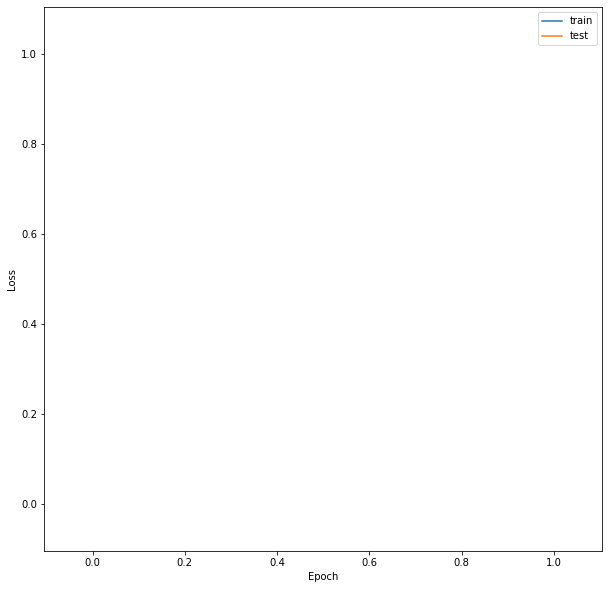

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(vae_model.loss_list_epoch, label='train')
plt.plot(vae_model.loss_list_epoch_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
vae_model.to('cpu')
data.to('cpu')

In [11]:
mu, logvar = vae_model.encoder(data.x_test)

In [12]:
x_reconstructed = vae_model.decoder(mu)
x_reconstructed = VAE.process_decoded_outputs(x_reconstructed, one_hot=vae_model.one_hot)
x_reconstructed_norm = torch.norm(x_reconstructed.float(), dim=-1)
x_norm = torch.norm(data.x_test.float(), dim=-1)

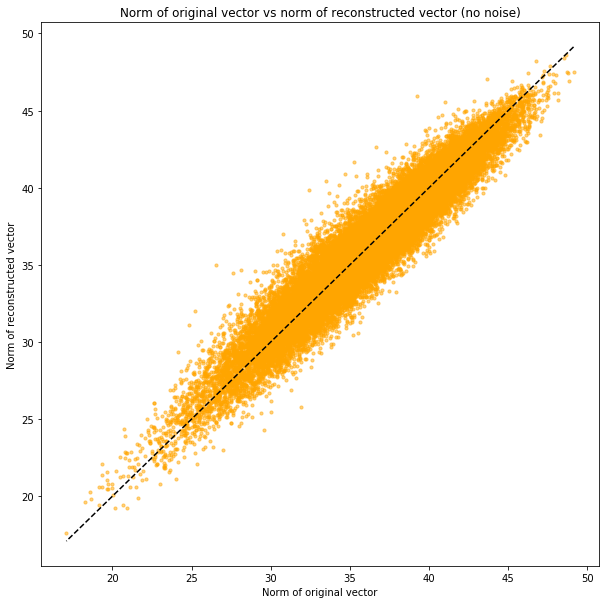

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(x_norm, x_reconstructed_norm, alpha=0.5, s=10, color='orange')
plt.plot([q.np.max(x_norm.numpy()), q.np.min(x_norm.numpy())], [q.np.max(x_norm.numpy()), q.np.min(x_norm.numpy())], color='black', linestyle='--')
plt.xlabel('Norm of original vector')
plt.ylabel('Norm of reconstructed vector')
plt.title('Norm of original vector vs norm of reconstructed vector (no noise)')
plt.show()

In [14]:
x_reconstructed_noise = vae_model.decoder(vae_model.reparameterize(mu, logvar))
x_reconstructed_noise = VAE.process_decoded_outputs(x_reconstructed_noise, one_hot=vae_model.one_hot)
x_reconstructed_noise_norm = torch.norm(x_reconstructed_noise.float(), dim=-1)

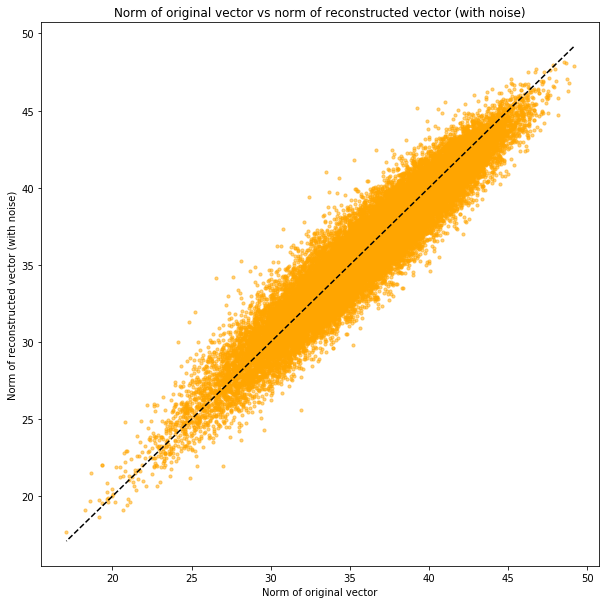

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(x_norm, x_reconstructed_noise_norm, alpha=0.5, s=10, color='orange')
plt.plot([q.np.max(x_norm.numpy()), q.np.min(x_norm.numpy())], [q.np.max(x_norm.numpy()), q.np.min(x_norm.numpy())], color='black', linestyle='--')
plt.xlabel('Norm of original vector')
plt.ylabel('Norm of reconstructed vector (with noise)')
plt.title('Norm of original vector vs norm of reconstructed vector (with noise)')
plt.show()

In [16]:
score_predicted = vae_model.score_predictor(mu)

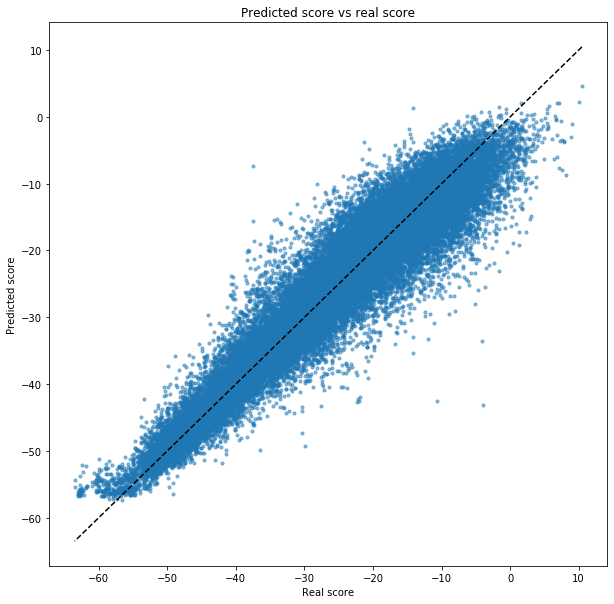

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(data.y_test.tolist(), score_predicted.tolist(), alpha=0.5, s=10)
plt.plot([q.np.max(data.y_test.numpy()), q.np.min(data.y_test.numpy())], [q.np.max((data.y_test).numpy()), q.np.min((data.y_test).numpy())], color='black', linestyle='--')
plt.xlabel('Real score')
plt.ylabel('Predicted score')
plt.title('Predicted score vs real score')
plt.show()

In [18]:
score_predicted = vae_model.score_predictor(vae_model.reparameterize(mu, logvar))

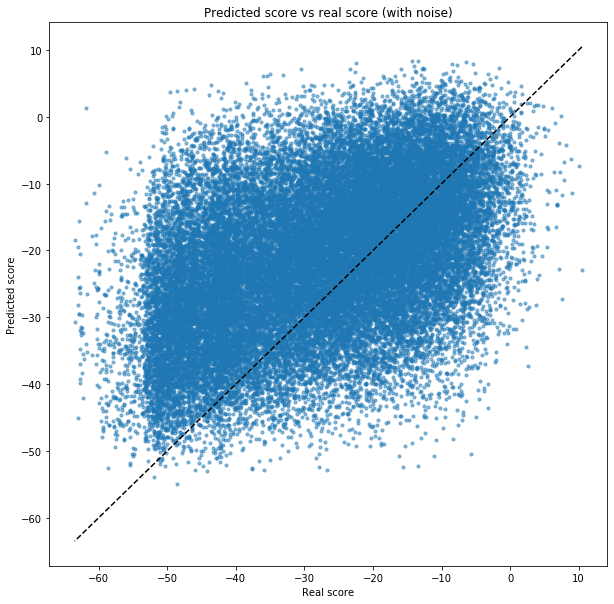

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(data.y_test.tolist(), score_predicted.tolist(), alpha=0.5, s=10)
plt.plot([q.np.max(data.y_test.numpy()), q.np.min(data.y_test.numpy())], [q.np.max((data.y_test).numpy()), q.np.min((data.y_test).numpy())], color='black', linestyle='--')
plt.xlabel('Real score')
plt.ylabel('Predicted score')
plt.title('Predicted score vs real score (with noise)')
plt.show()

In [30]:
# find vector in laten space that gives the lowest score
vector = torch.randn(1, 16)
vector.requires_grad = True
optimizer = optim.Adam([vector], lr=0.01)

for i in range(1000):

    optimizer.zero_grad()
    score_predicted = vae_model.score_predictor(vector)
    score_predicted.backward()
    optimizer.step()

    print(f'Epoch {i+1}/1000, score={score_predicted.item():.6f}                                                       ', end='\r')

    # early stopping
    patience = 20
    min_delta = 0.01
    if i > patience:
        score_difference = q.np.mean(score_predicted.item() - score_predicted.item()) - score_predicted.item()
        if score_difference < min_delta:
            print('Early stopping')
            break
print(vector, score_predicted.item())

tensor([[-1.3884, -1.4455, -3.0787,  2.3388, -0.9179, -0.8115, -0.2784,  0.2935,        
          1.3969,  0.3749,  0.7013,  0.3145, -0.3971,  0.5523, -0.4900,  0.3257]],
       requires_grad=True) -57.37295913696289


In [31]:
vector.requires_grad = False
vae_model.eval()

new_sequence = vae_model.decoder(vector)
new_sequence = VAE.process_decoded_outputs(new_sequence, one_hot=vae_model.one_hot)

score_new_sequence = vae_model.score_predictor(vae_model.encoder(new_sequence)[0])

print(f'New sequence: {new_sequence.tolist()}, score={score_new_sequence.item():.6f}')

New sequence: [[5, 15, 9, 6, 4, 8, 16, 11, 4, 6, 1, 4]], score=-11.303911


In [20]:
# def check_if_tensor_in_data(data, tensor):
#     in_test = torch.any(torch.all(data.x_test == tensor, dim=-1))
#     in_train = torch.any(torch.all(data.x_train == tensor, dim=-1))
#     return in_test or in_train

# def get_random_tensor(data, length=12, max_int=17):
#     tensor = torch.randint(0, max_int+1, (length,))
#     while check_if_tensor_in_data(data, tensor):
#         tensor = torch.randint(0, max_int+1, (length,))
#     return tensor

# def get_random_tensors(data, n_tensors, length=12, max_int=17):
#     tensors = []
#     for i in range(n_tensors):
#         print(i+1, '', end='\r')
#         tensors.append(get_random_tensor(data, length, max_int))
#     return torch.stack(tensors)

# data.to('cpu')
# random_x = get_random_tensors(data, n_tensors=100000, length=12, max_int=17)
# zeros_y = torch.zeros(len(random_x))

# #change type of tensors of random_x and zeros_y to old_x.dtype and old_y.dtype
# random_x = random_x.to(data.x_train.dtype)
# zeros_y = zeros_y.to(data.y_train.dtype)

# new_x = torch.cat((data.x_train.to('cpu'), random_x.to('cpu')), dim=0).to(device)
# new_y = torch.cat((data.y_train.to('cpu'), zeros_y.to('cpu')), dim=0).to(device)

# from torch.utils.data import DataLoader, TensorDataset
# new_data_loader = DataLoader(TensorDataset(new_x, new_y), batch_size=data_loader.batch_size, shuffle=True)

# data.to(device)

In [21]:
data.x_test[:100]

tensor([[12, 16, 11,  ..., 16, 10,  9],
        [ 5,  5,  2,  ..., 10, 13, 11],
        [ 5, 13, 16,  ..., 13,  4, 11],
        ...,
        [ 3,  5,  8,  ...,  7,  0, 12],
        [16, 16,  0,  ...,  5,  4,  4],
        [16, 12, 12,  ..., 11, 17,  5]], dtype=torch.int32)

In [22]:
x_reconstructed_test, mu_test, logvar_test = vae_model(data.x_test[:100])
x_reconstructed_test

ValueError: too many values to unpack (expected 3)

In [ ]:
loss = VAE.loss_function(x_reconstructed_test, data.x_test[:100], mu_test, logvar_test, one_hot=vae_model.one_hot, reduction='mean')
print(f'Loss on test set: {loss.item():.6f}')

Loss on test set: 1780.327393


In [ ]:
pred = VAE.process_decoded_outputs(x_reconstructed_test, one_hot=vae_model.one_hot)
pred

tensor([[14, 16, 12,  ..., 16, 10, 12],
        [ 4,  4,  4,  ..., 14, 12, 13],
        [ 4, 14, 16,  ..., 12,  3, 12],
        ...,
        [ 3,  5,  7,  ...,  5,  2, 14],
        [15, 16,  0,  ...,  5,  4,  4],
        [15, 11, 12,  ..., 12, 13,  4]], device='cuda:0', dtype=torch.int32)

In [ ]:
accuracy = (pred == data.x_test[:100]).float().mean().item()
accuracy

0.30000001192092896

In [ ]:
for x, p in zip(data.x_test, pred):
    print(x.tolist(), p.tolist())

[12, 16, 11, 3, 12, 3, 2, 1, 13, 16, 10, 9] [14, 16, 12, 3, 12, 2, 4, 3, 14, 16, 10, 12]
[5, 5, 2, 5, 15, 3, 16, 15, 16, 10, 13, 11] [4, 4, 4, 4, 14, 4, 16, 14, 15, 14, 12, 13]
[5, 13, 16, 16, 3, 7, 2, 7, 10, 13, 4, 11] [4, 14, 16, 16, 2, 7, 3, 7, 13, 12, 3, 12]
[10, 3, 10, 0, 8, 3, 5, 2, 4, 16, 5, 11] [13, 4, 9, 3, 10, 2, 5, 4, 6, 16, 7, 12]
[17, 16, 11, 7, 11, 2, 3, 16, 12, 0, 10, 2] [16, 16, 11, 8, 13, 1, 3, 15, 13, 2, 13, 3]
[16, 16, 1, 10, 5, 15, 6, 10, 12, 16, 5, 11] [15, 15, 0, 11, 3, 15, 5, 10, 13, 15, 4, 12]
[12, 16, 11, 11, 0, 9, 15, 5, 7, 16, 3, 2] [15, 16, 11, 15, 0, 11, 15, 6, 8, 14, 2, 2]
[3, 5, 11, 5, 13, 13, 0, 13, 17, 17, 0, 1] [5, 4, 10, 5, 13, 14, 2, 12, 15, 15, 4, 4]
[2, 14, 3, 5, 8, 13, 6, 5, 2, 7, 0, 6] [4, 16, 3, 5, 9, 14, 3, 4, 4, 7, 1, 4]
[16, 5, 14, 9, 3, 1, 0, 16, 3, 17, 5, 14] [15, 3, 15, 10, 3, 3, 3, 15, 5, 14, 5, 13]
[12, 5, 0, 16, 14, 2, 11, 6, 11, 16, 4, 9] [12, 5, 2, 16, 12, 3, 10, 3, 12, 16, 4, 10]
[13, 7, 12, 2, 0, 6, 6, 2, 9, 5, 13, 3] [13, 5, 12, 1,

In [ ]:
for x, p in zip(data.x_test, x_reconstructed_test):
    print(x.tolist(), p.tolist())

[12, 16, 11, 3, 12, 3, 2, 1, 13, 16, 10, 9] [14.144230842590332, 15.611113548278809, 12.067825317382812, 3.142987012863159, 11.509044647216797, 1.5868299007415771, 4.047634601593018, 3.0503456592559814, 14.309393882751465, 15.94442367553711, 10.253666877746582, 12.35794734954834]
[5, 5, 2, 5, 15, 3, 16, 15, 16, 10, 13, 11] [3.8819241523742676, 4.333313465118408, 3.607973337173462, 3.751281261444092, 13.501014709472656, 3.7417407035827637, 15.623453140258789, 13.998591423034668, 14.970654487609863, 13.72558307647705, 11.586260795593262, 13.32337760925293]
[5, 13, 16, 16, 3, 7, 2, 7, 10, 13, 4, 11] [4.396600723266602, 14.265751838684082, 16.47396469116211, 16.02397346496582, 1.8799333572387695, 7.235604763031006, 3.362311601638794, 6.559706211090088, 13.185684204101562, 11.79377269744873, 2.7009334564208984, 12.230436325073242]
[10, 3, 10, 0, 8, 3, 5, 2, 4, 16, 5, 11] [13.027217864990234, 3.769914150238037, 8.802730560302734, 3.3196163177490234, 9.94933795928955, 2.28277850151062, 5.0766